In [61]:
import pandas as pd
import numpy as np
import re
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer, confusion_matrix, plot_confusion_matrix, roc_curve, auc, classification_report
from sklearn import svm
from imblearn.over_sampling import SMOTE



import warnings
warnings.filterwarnings("ignore")

In [2]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\suki9\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\suki9\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\suki9\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


True

In [3]:
# Import data
data = pd.read_csv('Dataset1_labeled_data.csv')

In [4]:
# hate speech: 0
# offensive language: 1
# neither: 2

data.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [5]:
# Check for NaN values:
data.isnull().sum()

Unnamed: 0            0
count                 0
hate_speech           0
offensive_language    0
neither               0
class                 0
tweet                 0
dtype: int64

In [6]:
# Size of dataset

data.shape
print('{} rows with {} columns'.format(data.shape[0],data.shape[1]))

24783 rows with 7 columns


In [7]:
# Distribution of Class
data['class'].value_counts()

1    19190
2     4163
0     1430
Name: class, dtype: int64

In [8]:
hate, offensive, neither = np.bincount(data['class'])
total = hate + offensive + neither
print(f'hate speech:\n    Total: {total}\n    hate: {hate} ({(100 * hate / total):.2f}% of total)\n')
print(f'offensive speech:\n    Total: {total}\n    Offensive: {offensive} ({(100 * offensive / total):.2f}% of total)\n')
print(f'neither:\n    Total: {total}\n    Neither: {neither} ({(100 * neither / total):.2f}% of total)\n')

hate speech:
    Total: 24783
    hate: 1430 (5.77% of total)

offensive speech:
    Total: 24783
    Offensive: 19190 (77.43% of total)

neither:
    Total: 24783
    Neither: 4163 (16.80% of total)



We have imbalanced dataset

In [9]:
# Make a new column to highlight retweets
data['is_retweet'] = data['tweet'].apply(lambda x: x[:2]=='RT')
data['is_retweet'].sum()  # number of retweets

6484

In [10]:
# number of unique retweets
data.loc[data['is_retweet']].tweet.unique().size

6484

### Extracting substrings (@, #)

In [11]:
# Who is being retweeted?
# Who is being tweeted at/mentioned?
# What hashtags are being used?

# Create functions

def find_retweeted(tweet):
    '''This function will extract the twitter handles of retweet people'''
    return re.findall('(?<=RT\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', tweet)

def find_mentioned(tweet):
    '''This function will extract the twitter handles of people mentioned in the tweet'''
    return re.findall('(?<!RT\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', tweet)  

def find_hashtags(tweet):
    '''This function will extract hashtags'''
    return re.findall('(#[A-Za-z]+[A-Za-z0-9-_]+)', tweet)   

In [12]:
# Make new columns for retweeted usernames, mentioned usernames and hashtags

data['retweeted'] = data.tweet.apply(find_retweeted)
data['mentioned'] = data.tweet.apply(find_mentioned)
data['hashtags'] = data.tweet.apply(find_hashtags)

In [13]:
# Have a look at the new columns

data.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet,is_retweet,retweeted,mentioned,hashtags
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,False,[@mayasolovely],[],[]
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,False,[@mleew17],[],[]
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,False,[@UrKindOfBrand],[],[]
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,False,[@C_G_Anderson],[@viva_based],[]
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,False,[@ShenikaRoberts],[],[]


#### What hashtags are being used 

In [10]:
# Take the rows from the hashtag columns where there are actually hashtags

hashtags_list_data = data.loc[
                       data.hashtags.apply(
                           lambda hashtags_list: hashtags_list !=[]
                       ),['hashtags']]
hashtags_list_data.head()

,hashtags
37,[#Shots]
41,[#SevenOne]
45,[#HappyHumpDay]
72,[#ahmesehwetness]
73,"[#Eaglesnation, #Eagles]"


In [11]:
# Create dataframe where each use of hashtag gets its own row

flattened_hashtags_data = pd.DataFrame(
    [hashtag for hashtags_list in hashtags_list_data.hashtags
    for hashtag in hashtags_list],
    columns=['hashtag'])
flattened_hashtags_data.head()

,hashtag
0,#Shots
1,#SevenOne
2,#HappyHumpDay
3,#ahmesehwetness
4,#Eaglesnation


In [12]:
flattened_hashtags_data.shape

(3490, 1)

In [13]:
# Number of unique hashtags

flattened_hashtags_data['hashtag'].unique().size

2251

In [14]:
# Count of appearances of each hashtag
popular_hashtags = flattened_hashtags_data.groupby('hashtag').size()\
                                        .reset_index(name='counts')\
                                        .sort_values('counts', ascending=False)\
                                        .reset_index(drop=True)
popular_hashtags.head(10)

,hashtag,counts
0,#Yankees,94
1,#iphone,50
2,#ipad,48
3,#sex,48
4,#android,48
5,#porn,48
6,#xxx,48
7,#tcot,41
8,#hoosiers,23
9,#morningjoe,22


#### Who is being retweeted 

In [15]:
# Take the rows from the retweeted columns where there are actually hashtags

retweeted_list_data = data.loc[
                       data.retweeted.apply(
                           lambda retweeted_list: retweeted_list !=[]
                       ),['retweeted']]
retweeted_list_data.head()


,retweeted
0,[@mayasolovely]
1,[@mleew17]
2,[@UrKindOfBrand]
3,[@C_G_Anderson]
4,[@ShenikaRoberts]


In [16]:
# Create dataframe where each use of retweeted gets its own row

flattened_retweeted_data = pd.DataFrame(
    [retweeted for retweeted_list in retweeted_list_data.retweeted
    for retweeted in retweeted_list],
    columns=['retweeted'])
flattened_retweeted_data.head()


,retweeted
0,@mayasolovely
1,@mleew17
2,@UrKindOfBrand
3,@C_G_Anderson
4,@ShenikaRoberts


In [17]:
flattened_retweeted_data.shape

(7073, 1)

In [18]:
# Number of unique retweeted

flattened_retweeted_data['retweeted'].unique().size

5296

In [19]:
# Count of appearances of each retweeted
popular_retweeted = flattened_retweeted_data.groupby('retweeted').size()\
                                        .reset_index(name='counts')\
                                        .sort_values('counts', ascending=False)\
                                        .reset_index(drop=True)
popular_retweeted.head(10)

,retweeted,counts
0,@iDntWearCondoms,25
1,@Yankees,24
2,@JoeBudden,23
3,@CauseWereGuys,22
4,@KINGTUNCHI_,19
5,@FriendlyAssh0le,19
6,@KingHorseDick,19
7,@FunnyPicsDepot,15
8,@CuhCuhCuh,15
9,@SteveStfler,14


#### Who is being tweeted at/mentioned

In [20]:
# Take the rows from the mentioned columns where there are actually hashtags

mentioned_list_data = data.loc[
                       data.mentioned.apply(
                           lambda mentioned_list: mentioned_list !=[]
                       ),['mentioned']]
mentioned_list_data.head()



,mentioned
3,[@viva_based]
5,[@T_Madison_x]
7,[@selfiequeenbri]
9,[@rhythmixx_]
52,[@DaRealKha]


In [21]:
# Create dataframe where each use of mentioned gets its own row

flattened_mentioned_data = pd.DataFrame(
    [mentioned for mentioned_list in mentioned_list_data.mentioned
    for mentioned in mentioned_list],
    columns=['mentioned'])
flattened_mentioned_data.head()

,mentioned
0,@viva_based
1,@T_Madison_x
2,@selfiequeenbri
3,@rhythmixx_
4,@DaRealKha


In [22]:
flattened_mentioned_data.shape

(10958, 1)

In [23]:
# Number of unique retweeted

flattened_mentioned_data['mentioned'].unique().size

7039

In [24]:
# Count of appearances of each retweeted
popular_mentioned = flattened_mentioned_data.groupby('mentioned').size()\
                                        .reset_index(name='counts')\
                                        .sort_values('counts', ascending=False)\
                                        .reset_index(drop=True)
popular_mentioned.head(10)

,mentioned,counts
0,@kieffer_jason,101
1,@Yankees,46
2,@Huntermoore,30
3,@Buckm00se,23
4,@sbsylvester,22
5,@what_evaittakes,20
6,@VoiceOfDStreetz,19
7,@JawShoeeAhhh,18
8,@Leelucas_,18
9,@viaNAWF,18


### Wordcloud for 3 categories of tweets

<class 'set'>


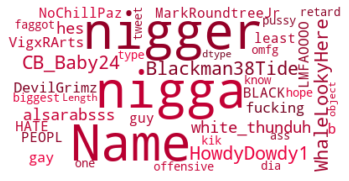

In [212]:
# Hate Speech

from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
stopwords.add("RT")

print(type(STOPWORDS))

import random

def random_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = 344
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=200,
                          max_font_size=60, 
                          random_state=42
                         ).generate(str(data.loc[data["class"]== 0].tweet))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud.recolor(color_func= random_color_func, random_state=3),
           interpolation="bilinear")
plt.axis('off')
plt.show()

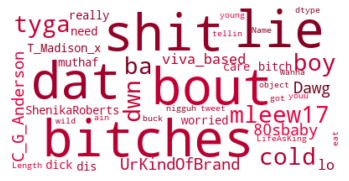

In [213]:
# Offensive Language 

def random_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = 344
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=200,
                          max_font_size=60, 
                          random_state=42
                         ).generate(str(data.loc[data["class"]== 1].tweet))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud.recolor(color_func= random_color_func, random_state=3),
           interpolation="bilinear")
plt.axis('off')
plt.show()

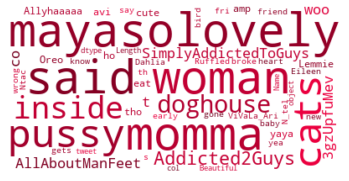

In [214]:
# Neither

def random_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = 344
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=200,
                          max_font_size=60, 
                          random_state=42
                         ).generate(str(data.loc[data["class"]== 2].tweet))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud.recolor(color_func= random_color_func, random_state=3),
           interpolation="bilinear")
plt.axis('off')
plt.show()

### Cleaning Unstructured Text Data

In [15]:
# Create functions

def remove_links(tweet):
    '''Takes a string and removes web links from it'''
    tweet = re.sub(r'http\S+', '', tweet) # remove http links
    tweet = re.sub(r'bit.ly/\S+', '', tweet) # rempve bitly links
    tweet = tweet.strip('[link]') # remove [links]
    return tweet

def remove_users(tweet):
    '''Takes a string and removes retweet and @user information'''
    tweet = re.sub('(RT\s@[A-Za-z0-9-_]+[A-Za-z0-9-_]+)', '', tweet) # remove retweet
    tweet = re.sub('(@[A-Za-z0-9-_]+[A-Za-z0-9-_]+)', '', tweet) # remove tweeted at
    return tweet

In [14]:
my_stopwords = nltk.corpus.stopwords.words('english')
word_rooter = nltk.stem.snowball.PorterStemmer(ignore_stopwords=False).stem
my_punctuation = '!"$%&\'()*+,-./:;<=>?[\\]\\\\\^_`{|}~•@#'

# cleaning master function
def clean_tweet(tweet, bigrams=False):
    tweet = remove_users(tweet)
    tweet = remove_links(tweet)
    tweet = tweet.lower() # lower case
    tweet = re.sub('['+my_punctuation + ']+', ' ', tweet) # strip punctuation
    tweet = re.sub('\s+', ' ', tweet) #remove double spacing
    tweet = re.sub('([0-9]+)', '', tweet) # remove numbers
    tweet = re.sub('amp', '', tweet) # remove amp
    tweet = re.sub(r'\s+', ' ', tweet)
    tweet_token_list = [word for word in tweet.split(' ')
                            if word not in my_stopwords] # remove stopwords

    tweet_token_list = [word_rooter(word) if '#' not in word else word
                        for word in tweet_token_list] # apply word rooter
    if bigrams:
        tweet_token_list = tweet_token_list+[tweet_token_list[i]+'_'+tweet_token_list[i+1]
                                            for i in range(len(tweet_token_list)-1)]
    tweet = ' '.join(tweet_token_list)
    return tweet

In [16]:
data['clean_tweet'] = data.tweet.apply(clean_tweet)
data.head(30)

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet,is_retweet,retweeted,mentioned,hashtags,clean_tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,False,[@mayasolovely],[],[],woman complain clean hous man alway take trash
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,False,[@mleew17],[],[],boy dat cold tyga dwn bad cuffin dat hoe st p...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,False,[@UrKindOfBrand],[],[],dawg ever fuck bitch start cri confus shit
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,False,[@C_G_Anderson],[@viva_based],[],look like tranni
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,False,[@ShenikaRoberts],[],[],shit hear might true might faker bitch told ya
5,5,3,1,2,0,1,"!!!!!!!!!!!!!!!!!!""@T_Madison_x: The shit just...",False,[],[@T_Madison_x],[],shit blow claim faith somebodi still fuck hoe
6,6,3,0,3,0,1,"!!!!!!""@__BrighterDays: I can not just sit up ...",False,[],[],[],sit hate anoth bitch got much shit go
7,7,3,0,3,0,1,!!!!&#8220;@selfiequeenbri: cause I'm tired of...,False,[],[@selfiequeenbri],[],caus tire big bitch come us skinni girl
8,8,3,0,3,0,1,""" &amp; you might not get ya bitch back &amp; ...",False,[],[],[],might get ya bitch back that
9,9,3,1,2,0,1,""" @rhythmixx_ :hobbies include: fighting Maria...",False,[],[@rhythmixx_],[],hobbi includ fight mariam bitch


In [18]:
# Converting Text to Numbers

X = data['clean_tweet']
y = data['class']

from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(ngram_range=(2,2))
X = cv.fit_transform(data['clean_tweet']).toarray()

In [19]:
# Split our data into a training set and a testing set


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
df_cv = pd.DataFrame(X, columns = cv.get_feature_names())
df_cv.head(10)

,aa bfmv,aa blink,aa class,aa lol,aa miw,aaaaaaaaand begin,aaahhhhh internet,aahahah fuck,aan de,aap maoist,...,zoom maxi,zoom see,zoom still,zorro le,zorro se,zrgrizz stop,zucchini cucumb,zuko get,zulema worri,zulu look
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Logistic regression model

In [27]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC


# Logistic Regression:
text_clf_logr = Pipeline([('clf', LogisticRegression())])

# Naïve Bayes:
text_clf_nb = Pipeline([('clf', MultinomialNB())])

# Linear SVC:
text_clf_lsvc = Pipeline([('clf', LinearSVC())])



## Logistic Regression:

In [28]:
text_clf_logr.fit(X_train, y_train)

Pipeline(steps=[('clf', LogisticRegression())])

In [29]:
# Form a prediction set
predictions = text_clf_logr.predict(X_test)

In [30]:
# Report the confusion matrix
from sklearn import metrics
print(metrics.confusion_matrix(y_test,predictions))

[[  18  269    3]
 [  14 3793   25]
 [   2  680  153]]


In [31]:
# OR
# Results

pd.crosstab(y_test, predictions, rownames=["Actual"], colnames=["Predicted"])

Predicted,0,1,2
Actual,,,
0,18,269,3
1,14,3793,25
2,2,680,153


In [32]:
print(metrics.classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.53      0.06      0.11       290
           1       0.80      0.99      0.88      3832
           2       0.85      0.18      0.30       835

    accuracy                           0.80      4957
   macro avg       0.72      0.41      0.43      4957
weighted avg       0.79      0.80      0.74      4957



In [33]:
## Seems like we need to handle the imbalanced dataset problem

## Naïve Bayes:

In [34]:
text_clf_nb.fit(X_train, y_train)

Pipeline(steps=[('clf', MultinomialNB())])

In [35]:
# Form a prediction set
predictions = text_clf_nb.predict(X_test)

In [36]:
# Report the confusion matrix
from sklearn import metrics
print(metrics.confusion_matrix(y_test,predictions))

[[  72  164   54]
 [ 262 3245  325]
 [ 144  203  488]]


In [37]:
# Print a classification report
print(metrics.classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.15      0.25      0.19       290
           1       0.90      0.85      0.87      3832
           2       0.56      0.58      0.57       835

    accuracy                           0.77      4957
   macro avg       0.54      0.56      0.54      4957
weighted avg       0.80      0.77      0.78      4957



## Linear SVC:

In [38]:
text_clf_lsvc.fit(X_train, y_train)

Pipeline(steps=[('clf', LinearSVC())])

In [39]:
# Form a prediction set
predictions = text_clf_lsvc.predict(X_test)

In [40]:
# Report the confusion matrix
from sklearn import metrics
print(metrics.confusion_matrix(y_test,predictions))


[[  36  249    5]
 [  37 3748   47]
 [   4  608  223]]


In [41]:
# Print a classification report
print(metrics.classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.47      0.12      0.20       290
           1       0.81      0.98      0.89      3832
           2       0.81      0.27      0.40       835

    accuracy                           0.81      4957
   macro avg       0.70      0.46      0.50      4957
weighted avg       0.79      0.81      0.77      4957



## Test traditional models

In [42]:
df = data['clean_tweet']
target = data['class']

In [43]:
# Tokenizing
# function to tokenize 

def unfiltered_tokens(text):
    dirty_tokens = nltk.word_tokenize(text)
    return dirty_tokens

In [44]:
# applying this function to the `clean_tweets` column

processed_data = list(map(unfiltered_tokens, df))

In [45]:
# morphing `processed_data` into a readable list

flat_unfiltered = [item for sublist in processed_data for item in sublist]

In [46]:
# getting frequency distribution
corpus_freqdist = FreqDist(flat_unfiltered)

# top 20 words in the corpus
corpus_freqdist.most_common(20)

[('bitch', 11479),
 ('hoe', 4352),
 ('like', 2867),
 ('pussi', 2267),
 ('fuck', 2240),
 ('nigga', 2004),
 ('get', 1785),
 ('got', 1613),
 ('ass', 1598),
 ('shit', 1311),
 ('u', 1308),
 ('trash', 1167),
 ('go', 914),
 ('know', 885),
 ('love', 773),
 ('one', 764),
 ('look', 763),
 ('want', 753),
 ('make', 713),
 ('say', 689)]

In [47]:
total_vocab = set()
for comment in processed_data:
    total_vocab.update(comment)
len(total_vocab)

# Our corpus has a vocabulary of 15671. 
# This would also be the number of columns in the sparse matrix after we vectorize the data later.

15671

In [48]:
# Lemmatization: it reduces each word into a linguistically valid lemma, or root word. 
# It does this through linguistic mappings, using the WordNet lexical database.

# creating a list with all lemmatized outputs
lemmatizer = WordNetLemmatizer() 
lemmatized_output = []

for listy in processed_data:
    lemmed = ' '.join([lemmatizer.lemmatize(w) for w in listy])
    lemmatized_output.append(lemmed)

In [49]:
X_lem = lemmatized_output
y_lem = target

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X_lem, y_lem, test_size=0.2, random_state= 20)

# using tf_idf vectorizor
cv2 = CountVectorizer(ngram_range = (2,2))

In [51]:
# sparse matrix format with 15671 stored elements
cv_data_train = cv2.fit_transform(X_train)
cv_data_test = cv2.transform(X_test)

In [53]:
# taking a quick look of the non zero elements
non_zero_cols = cv_data_train.nnz / float(cv_data_train.shape[0])
print("Average Number of Non-Zero Elements in Vectorized Articles: {}".format(non_zero_cols))

percent_sparse = 1 - (non_zero_cols / float(cv_data_train.shape[1]))
print('Percentage of columns containing ZERO: {}'.format(percent_sparse))

# 99.9% of the columns contain a zero, meaning that's a very sparse matrix

Average Number of Non-Zero Elements in Vectorized Articles: 6.227226873802078
Percentage of columns containing ZERO: 0.9999279039193067


In [54]:
# creating single df for training set
X_train_df = pd.DataFrame(data=cv_data_train, index=None, columns=['clean_tweet']) 
y_train_df = pd.DataFrame(data=y_train, index=None, columns=['class']) 
# joining them
training = pd.concat([X_train_df, y_train_df], axis=1)

In [55]:
training.head(2)

,clean_tweet,class
0,"(0, 71614)\t1\n (0, 19532)\t1\n (0, 35567)...",2.0
1,"(0, 74009)\t1\n (0, 30303)\t1\n (0, 36816)...",1.0


In [56]:
# separate minority and majority classes
hate = training[training['class']==0]
offensive = training[training['class']==1]
neither = training[training['class']==2]


In [57]:
print(hate.shape)
print(offensive.shape)
print(neither.shape)

(1156, 2)
(15335, 2)
(3335, 2)


We can see that this data has a huge class imbalance. After running a baseline, we can try oversampling the minority class (hate speech) with SMOTE and undersampling the majority class with Tomek Links.

### Baseline Random Forest

In [58]:
rf_baseline = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=0)
# adding class_weight='balanced' increased accuracy & precision but decreased F1

In [59]:
rf_baseline.fit(cv_data_train, y_train)
rf_test_preds = rf_baseline.predict(cv_data_test)

rf_baseline_report = classification_report(y_test, rf_test_preds)
print(rf_baseline_report)

              precision    recall  f1-score   support

           0       0.10      0.58      0.16       274
           1       0.93      0.72      0.81      3855
           2       0.84      0.30      0.45       828

    accuracy                           0.64      4957
   macro avg       0.62      0.53      0.47      4957
weighted avg       0.87      0.64      0.71      4957



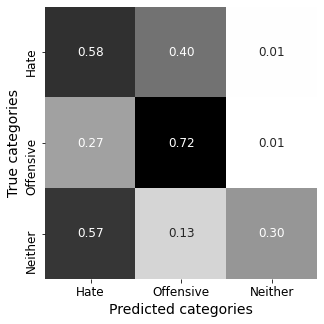

In [63]:
import seaborn 

conf_matrix = confusion_matrix(y_test, rf_test_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = conf_matrix[i,:]/float(conf_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)

### Baseline Logistic Regression

In [64]:
logreg_baseline = LogisticRegression(penalty='l2', class_weight='balanced', random_state=20)

In [67]:
logreg_baseline.fit(cv_data_train, y_train)
logreg_test_preds = logreg_baseline.predict(cv_data_test)

logreg_baseline_report = classification_report(y_test, logreg_test_preds)
print(logreg_baseline_report)

              precision    recall  f1-score   support

           0       0.36      0.20      0.26       274
           1       0.83      0.96      0.89      3855
           2       0.84      0.37      0.51       828

    accuracy                           0.82      4957
   macro avg       0.68      0.51      0.55      4957
weighted avg       0.81      0.82      0.79      4957



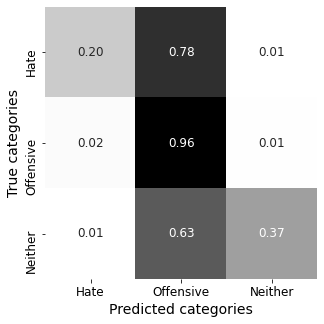

In [68]:
conf_matrix = confusion_matrix(y_test, logreg_test_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = conf_matrix[i,:]/float(conf_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
sns.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)

### Baseline with SMOTE

In [69]:
sm = SMOTE(random_state=35)
smote_X_train, smote_y_train = sm.fit_sample(cv_data_train, y_train)

In [70]:
smote_logreg = LogisticRegression(penalty='l2', random_state=35)

smote_logreg.fit(smote_X_train, smote_y_train)
smote_logreg_test_preds = smote_logreg.predict(cv_data_test)

smote_logreg_report = classification_report(y_test, smote_logreg_test_preds)
print(smote_logreg_report)

              precision    recall  f1-score   support

           0       0.10      0.61      0.17       274
           1       0.95      0.65      0.77      3855
           2       0.66      0.50      0.57       828

    accuracy                           0.62      4957
   macro avg       0.57      0.59      0.50      4957
weighted avg       0.85      0.62      0.70      4957



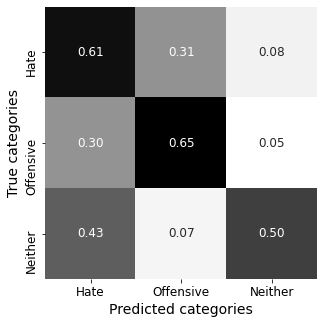

In [71]:
conf_matrix = confusion_matrix(y_test, smote_logreg_test_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = conf_matrix[i,:]/float(conf_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
sns.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)

### Baseline with Tomek Links¶

In [72]:
# Under-sample the majority class (offensive)

from collections import Counter
from imblearn.under_sampling import TomekLinks # doctest: +NORMALIZE_WHITESPACE

tl = TomekLinks()
tomek_X_train, tomek_y_train = tl.fit_resample(cv_data_train, y_train)
print('Resampled dataset shape %s' % Counter(tomek_y_train))

# It only removed 545 values from the majority class.

Resampled dataset shape Counter({1: 15313, 2: 3320, 0: 1156})


In [73]:
tomek_logreg = LogisticRegression(penalty='l2', random_state=55)

tomek_logreg.fit(tomek_X_train, tomek_y_train)
tomek_logreg_test_preds = tomek_logreg.predict(cv_data_test)

tomek_logreg_report = classification_report(y_test, tomek_logreg_test_preds)
print(tomek_logreg_report)

              precision    recall  f1-score   support

           0       0.62      0.07      0.13       274
           1       0.81      0.99      0.89      3855
           2       0.84      0.19      0.31       828

    accuracy                           0.81      4957
   macro avg       0.76      0.42      0.44      4957
weighted avg       0.80      0.81      0.75      4957



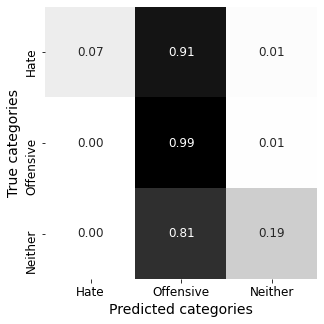

In [74]:
conf_matrix = confusion_matrix(y_test, tomek_logreg_test_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = conf_matrix[i,:]/float(conf_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
sns.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)

### Grid Search 

In [75]:
# creating the model
baseline_model = LogisticRegression(class_weight='balanced', random_state=50)

In [76]:
# creating param_dict
param_dict={'penalty': ['l1', 'l2'], 'solver': ['liblinear', 'newton-cg', 'sag'], 'C':
[100, 10, 1.0, 0.1, 0.01]}

In [77]:
# instantiate Grid Search CV with F1 metric
from sklearn.metrics import f1_score, make_scorer
f1 = make_scorer(f1_score , average='weighted')
grid_baseline = GridSearchCV(baseline_model, param_dict, cv=5, scoring= f1, verbose=1)

In [78]:
# fit the grid search to our data
grid_baseline.fit(cv_data_train, y_train)

# generate score with .best_score_ and hyperparemeters with .best_params_
print('F1 Score:', grid_baseline.best_score_)
print('Best Hyperparameters:', grid_baseline.best_params_)
print('Model object with best parameters: ')
print(grid_baseline.best_estimator_)


Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  5.0min finished


F1 Score: 0.7859540709652413
Best Hyperparameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
Model object with best parameters: 
LogisticRegression(C=0.1, class_weight='balanced', random_state=50,
                   solver='newton-cg')


In [79]:
grid_base_test_preds = grid_baseline.best_estimator_.predict(cv_data_test)

grid_base_logreg_report = classification_report(y_test, grid_base_test_preds)
print(grid_base_logreg_report)

              precision    recall  f1-score   support

           0       0.32      0.23      0.27       274
           1       0.85      0.94      0.89      3855
           2       0.76      0.45      0.56       828

    accuracy                           0.82      4957
   macro avg       0.64      0.54      0.57      4957
weighted avg       0.80      0.82      0.80      4957



### Running This Tuned Baseline on SMOTE Data

In [80]:
# best model according to grid search
smote_tuned = LogisticRegression(C=1.0, class_weight='balanced', penalty='l1', random_state=50,
                   solver='liblinear')

smote_tuned.fit(smote_X_train, smote_y_train)
smote_tuned_test_preds = smote_tuned.predict(cv_data_test)

smote_tuned_logreg_report = classification_report(y_test, smote_tuned_test_preds)
print(smote_tuned_logreg_report)

              precision    recall  f1-score   support

           0       0.10      0.65      0.17       274
           1       0.94      0.66      0.77      3855
           2       0.69      0.34      0.45       828

    accuracy                           0.60      4957
   macro avg       0.58      0.55      0.46      4957
weighted avg       0.85      0.60      0.69      4957



### Baseline Naive Bayes

In [81]:
baseline_bayes = MultinomialNB(alpha = .01)

baseline_bayes.fit(cv_data_train, y_train)
bayes_test_preds = baseline_bayes.predict(cv_data_test)

bayes_baseline_report = classification_report(y_test, bayes_test_preds)
print(bayes_baseline_report)

              precision    recall  f1-score   support

           0       0.31      0.19      0.24       274
           1       0.85      0.95      0.90      3855
           2       0.78      0.43      0.55       828

    accuracy                           0.82      4957
   macro avg       0.65      0.52      0.56      4957
weighted avg       0.81      0.82      0.80      4957



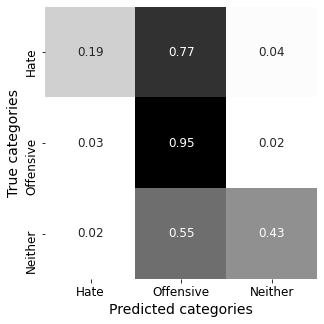

In [82]:
confusion_matrix = confusion_matrix(y_test, bayes_test_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
sns.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)

### Baseline SVM

In [83]:
SVM_baseline = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto', class_weight='balanced')

SVM_baseline.fit(cv_data_train, y_train)
SVM_test_preds = SVM_baseline.predict(cv_data_test)

SVM_baseline_report = classification_report(y_test, SVM_test_preds)
print(SVM_baseline_report)

              precision    recall  f1-score   support

           0       0.34      0.15      0.20       274
           1       0.82      0.97      0.89      3855
           2       0.84      0.28      0.42       828

    accuracy                           0.81      4957
   macro avg       0.66      0.46      0.50      4957
weighted avg       0.80      0.81      0.77      4957



In [84]:
conf_matrix = confusion_matrix(y_test, SVM_test_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = conf_matrix[i,:]/float(conf_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
sns.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)

TypeError: 'numpy.ndarray' object is not callable

Overall, the Baseline Logistic Regression model performed the best across recall(0.66) and F1(0.41). 